Generating animation frames...
Saving to fcnn_candidate_selection.gif...
Done! File saved.


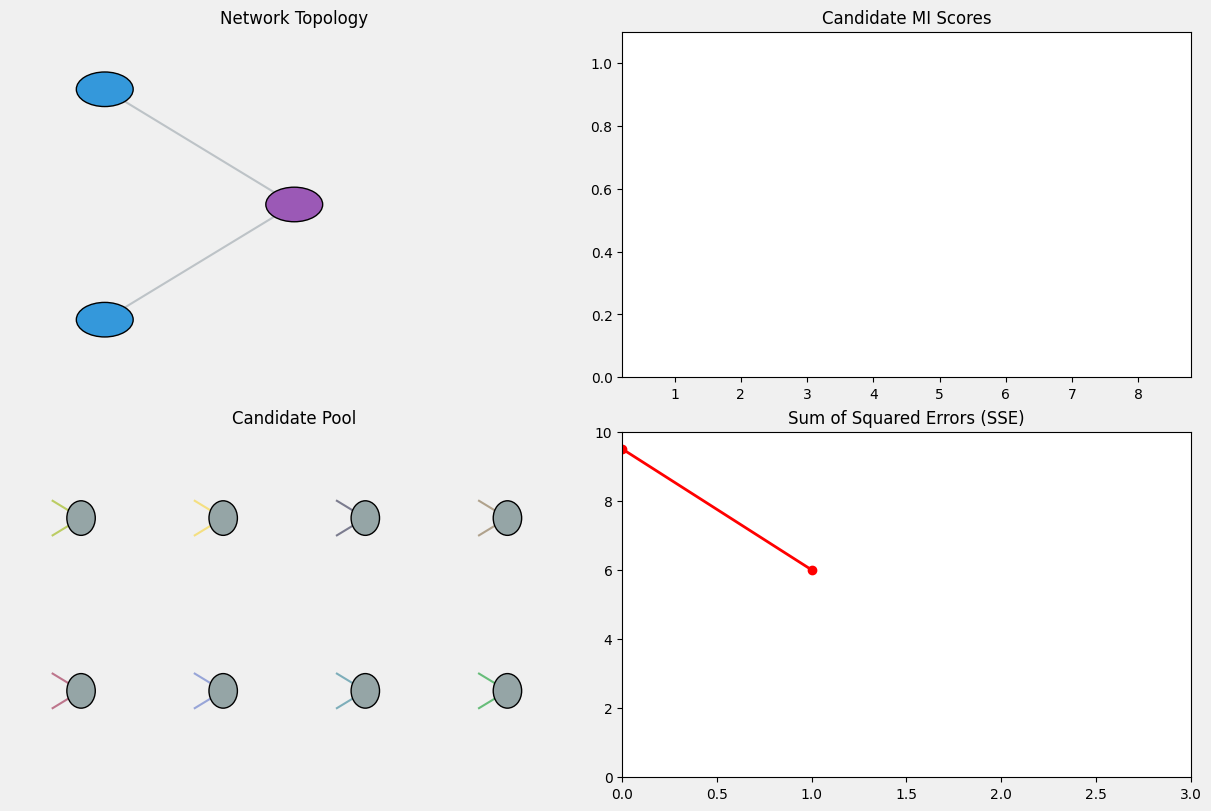

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Circle, ConnectionPatch

# ==========================================
# Configuration & Setup
# ==========================================
FPS = 15
DURATION_SEC = 10
TOTAL_FRAMES = FPS * DURATION_SEC

# Colors
COLOR_BG = '#f0f0f0'
COLOR_NODE_INPUT = '#3498db'  # Blue
COLOR_NODE_HIDDEN = '#9b59b6' # Purple
COLOR_CANDIDATE = '#95a5a6'   # Grey
COLOR_ACTIVE = '#e67e22'      # Orange (Processing)
COLOR_WINNER = '#f1c40f'      # Gold
COLOR_LINE = '#bdc3c7'

# Data Simulation
N_CANDIDATES = 8
WINNER_IDX = 4  # Candidate 5 (0-indexed is 4)
np.random.seed(42)

# Generate synthetic MI scores (make the winner distinct)
mi_scores = np.random.uniform(0.1, 0.6, N_CANDIDATES)
mi_scores[WINNER_IDX] = 0.95  # The clear winner

# Generate synthetic weights (just for visualization color)
candidate_weight_colors = [np.random.rand(3,) for _ in range(N_CANDIDATES)]

# ==========================================
# Figure Layout
# ==========================================
fig = plt.figure(figsize=(12, 8), constrained_layout=True)
fig.patch.set_facecolor(COLOR_BG)
gs = GridSpec(2, 2, figure=fig)

# 1. Top-Left: The Network
ax_net = fig.add_subplot(gs[0, 0])
ax_net.set_title("FCNN Network Topology")
ax_net.set_xlim(-1, 3)
ax_net.set_ylim(-1, 3)
ax_net.axis('off')

# 2. Top-Right: MI Scoreboard
ax_chart = fig.add_subplot(gs[0, 1])
ax_chart.set_title("Candidate MI Scores (Error Reduction Potential)")
ax_chart.set_xlim(-0.5, N_CANDIDATES - 0.5)
ax_chart.set_ylim(0, 1.1)
ax_chart.set_xlabel("Candidate ID")
ax_chart.set_ylabel("Modified Index (MI)")

# 3. Bottom-Left: Candidate Pool
ax_pool = fig.add_subplot(gs[1, 0])
ax_pool.set_title("Candidate Pool (Random Fixed Weights)")
ax_pool.set_xlim(0, 4)
ax_pool.set_ylim(0, 2)
ax_pool.axis('off')

# 4. Bottom-Right: SSE Curve
ax_sse = fig.add_subplot(gs[1, 1])
ax_sse.set_title("Sum of Squared Errors (SSE)")
ax_sse.set_xlim(0, 5)
ax_sse.set_ylim(0, 10)
ax_sse.set_xlabel("Hidden Units Added")

# ==========================================
# State Variables
# ==========================================
# Initial Network State (2 Inputs, 1 Hidden)
net_nodes = [
    (0, 2, COLOR_NODE_INPUT), (0, 0, COLOR_NODE_INPUT), # Inputs
    (1, 1, COLOR_NODE_HIDDEN) # Existing Hidden
]
net_connections = [(0, 2), (1, 2)] # Indices in net_nodes

sse_data_x = [0, 1]
sse_data_y = [9.5, 6.0]

# Candidate Grid Positions
pool_positions = []
rows = 2
cols = 4
for r in range(rows):
    for c in range(cols):
        pool_positions.append((c + 0.5, 1.5 - r)) # Grid layout

# ==========================================
# Helper Functions
# ==========================================
def draw_neuron(ax, x, y, color, radius=0.15, glow=False):
    """Draws a neuron circle."""
    if glow:
        glow_circle = Circle((x, y), radius*1.4, color=color, alpha=0.4)
        ax.add_patch(glow_circle)
    circle = Circle((x, y), radius, color=color, ec='black', zorder=10)
    ax.add_patch(circle)

def draw_network_lines(ax, start_pos, end_pos, color=COLOR_LINE, style='-'):
    ax.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]],
            color=color, linestyle=style, zorder=1)

# ==========================================
# Animation Update Function
# ==========================================
def update(frame):
    # Clear axes to redraw
    ax_net.clear()
    ax_chart.clear()
    ax_pool.clear()
    ax_sse.clear()

    # Reset chart settings after clear
    ax_net.set_title("Network Topology")
    ax_net.set_xlim(-0.5, 2.5)
    ax_net.set_ylim(-0.5, 2.5)
    ax_net.axis('off')

    ax_chart.set_title("Candidate MI Scores")
    ax_chart.set_ylim(0, 1.1)
    ax_chart.set_xticks(range(N_CANDIDATES))
    ax_chart.set_xticklabels([str(i+1) for i in range(N_CANDIDATES)])

    ax_pool.set_title("Candidate Pool")
    ax_pool.set_xlim(0, 4)
    ax_pool.set_ylim(0, 2)
    ax_pool.axis('off')

    ax_sse.set_title("Sum of Squared Errors (SSE)")
    ax_sse.set_xlim(0, 3)
    ax_sse.set_ylim(0, 10)

    # -----------------------------
    # TIMING LOGIC
    # -----------------------------
    # Phases:
    # 0-20: Intro (Show pool)
    # 20-80: Evaluation Loop (Scan candidates)
    # 80-100: Selection (Highlight Winner)
    # 100-120: Installation (Move to net)
    # 120+: Update SSE

    # 1. Draw Static Network (Input + Existing Hidden)
    # ----------------------------------------------
    # Draw connections
    for u, v in net_connections:
        p1 = net_nodes[u]
        p2 = net_nodes[v]
        draw_network_lines(ax_net, (p1[0], p1[1]), (p2[0], p2[1]))

    # Draw nodes
    for x, y, col in net_nodes:
        draw_neuron(ax_net, x, y, col)

    # 2. Draw SSE Curve
    # ----------------------------------------------
    ax_sse.plot(sse_data_x, sse_data_y, '-o', color='red', lw=2)
    if frame > 120:
         # Add projected drop
         ax_sse.plot([1, 2], [6.0, 2.5], '--', color='green', alpha=0.7)
         ax_sse.text(2, 2.7, "-SSE", color='green', fontweight='bold')

    # 3. Logic by Frame
    # ----------------------------------------------

    # Evaluation Phase
    current_cand_idx = -1

    if 20 <= frame < 80:
        # Map frame range to candidate index 0-7
        progress = (frame - 20) / 60
        current_cand_idx = int(progress * N_CANDIDATES)
        if current_cand_idx >= N_CANDIDATES: current_cand_idx = N_CANDIDATES - 1

    # Chart Bars
    bar_colors = []
    bar_heights = []

    for i in range(N_CANDIDATES):
        h = 0
        c = COLOR_CANDIDATE

        # logic for bar height
        if frame >= 80:
            h = mi_scores[i] # Full height
            if i == WINNER_IDX:
                c = COLOR_WINNER
            else:
                c = '#ecf0f1' # Fade others
        elif 20 <= frame < 80:
            if i < current_cand_idx:
                h = mi_scores[i] # Already scanned
            elif i == current_cand_idx:
                # Growing animation
                local_progress = ((frame - 20) % (60/N_CANDIDATES)) / (60/N_CANDIDATES)
                h = mi_scores[i] * local_progress
                c = COLOR_ACTIVE
            else:
                h = 0 # Not yet scanned

        bar_colors.append(c)
        bar_heights.append(h)

    ax_chart.bar(range(N_CANDIDATES), bar_heights, color=bar_colors)

    # Pool Visualization
    is_installed = frame >= 120

    for i, pos in enumerate(pool_positions):
        # Determine Color/State
        c = COLOR_CANDIDATE
        glow = False

        if frame < 80:
            if i == current_cand_idx:
                c = COLOR_ACTIVE
                glow = True
                # Show formula text
                ax_pool.text(2, -0.2, f"Calculating MI for Cand {i+1}...",
                             ha='center', fontsize=10, color=COLOR_ACTIVE)
        elif 80 <= frame < 120:
            if i == WINNER_IDX:
                c = COLOR_WINNER
                glow = True
                ax_pool.text(2, -0.2, f"Winner: Cand {i+1} (Max SSE Redux)",
                             ha='center', fontsize=10, color=COLOR_WINNER, fontweight='bold')
            else:
                c = '#ecf0f1' # Fade
        elif frame >= 120:
            # Installation phase
            if i == WINNER_IDX:
                continue # Don't draw in pool, draw in network
            c = '#ecf0f1' # Faded

        draw_neuron(ax_pool, pos[0], pos[1], c, radius=0.1, glow=glow)

        # Visualize random weights as small hair lines
        if not (is_installed and i == WINNER_IDX):
            ax_pool.plot([pos[0]-0.2, pos[0]], [pos[1]-0.1, pos[1]], color=candidate_weight_colors[i], alpha=0.6)
            ax_pool.plot([pos[0]-0.2, pos[0]], [pos[1]+0.1, pos[1]], color=candidate_weight_colors[i], alpha=0.6)

    # 4. Installation Animation
    # ----------------------------------------------
    if frame >= 120:
        # Draw the new node in the Network Panel
        new_x, new_y = 1.8, 1.0 # Position for new hidden unit

        # Connect to inputs and previous hidden
        # (Inputs are idx 0,1; Hidden is idx 2)
        # Draw lines
        for target in net_nodes:
            draw_network_lines(ax_net, (target[0], target[1]), (new_x, new_y), color=COLOR_WINNER)

        # Draw new node
        draw_neuron(ax_net, new_x, new_y, COLOR_WINNER, glow=True)
        ax_net.text(new_x, new_y + 0.3, "New Unit", ha='center', color=COLOR_WINNER)

        # Add point to SSE
        ax_sse.plot(2, 2.5, 'o', color='green')


# ==========================================
# Render
# ==========================================
print("Generating animation frames...")
anim = animation.FuncAnimation(fig, update, frames=TOTAL_FRAMES, interval=1000/FPS)

# Save
output_file = "fcnn_candidate_selection.gif"
print(f"Saving to {output_file}...")
try:
    anim.save(output_file, writer='pillow', fps=FPS)
    print("Done! File saved.")
except Exception as e:
    print(f"Error saving GIF: {e}")
    # Fallback to display if save fails (e.g. in notebooks)
    plt.show()s

Generating GIF...
Done! Saved as 'fcnn_construction.gif'


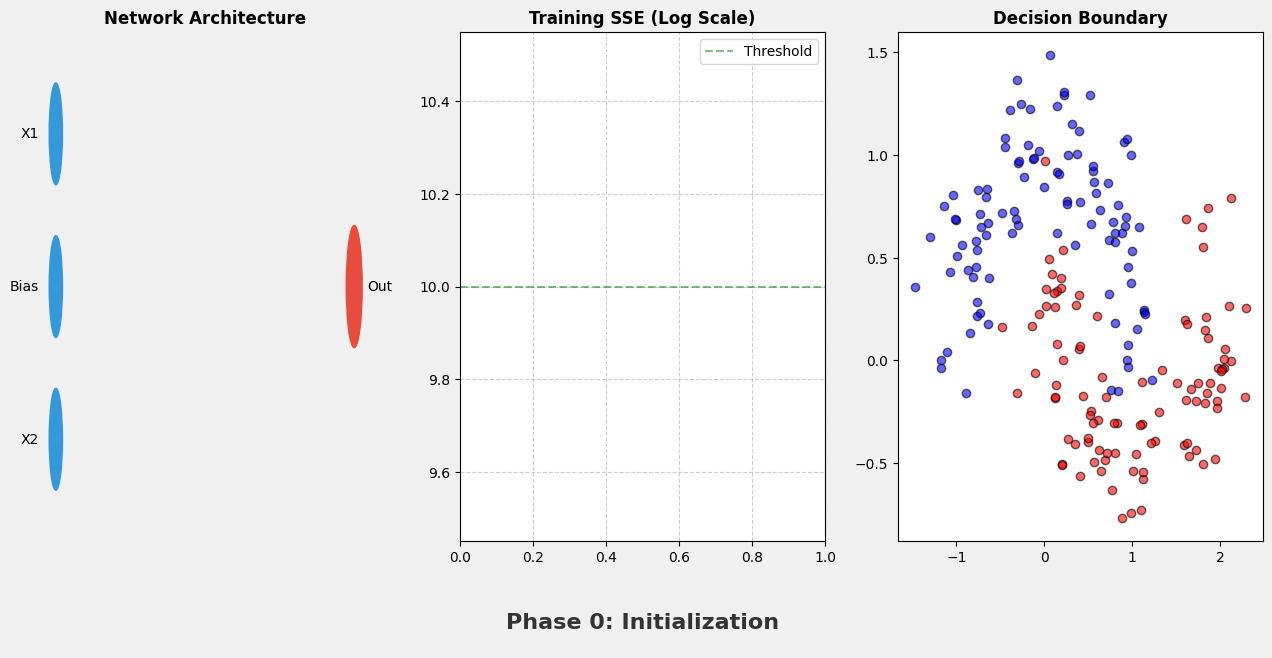

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
from sklearn.datasets import make_moons
import matplotlib.cm as cm

# ==========================================
# 1. FCNN Simulation Logic
# ==========================================
class FCNN_Simulator:
    def __init__(self, X, y, max_hidden=12):
        self.X = X  # Inputs
        self.y = y.reshape(-1, 1)  # Targets
        self.max_hidden = max_hidden

        # History for animation
        self.history = []

        # Current State
        self.N_samples, self.N_inputs = X.shape

        # Phase 0: Initialization (Empty)
        self.save_state("Phase 0: Initialization", [], np.inf, None)

        # Phase 1: Bias Only
        # Matrix A has shape (N, 1)
        self.A = np.ones((self.N_samples, 1))
        self.hidden_weights = []
        self.run_step("Phase 1: Add Bias Unit")

        # Phase 2: Add Original Inputs
        # Matrix A has shape (N, 3) -> [Bias, X1, X2]
        self.A = np.hstack([self.A, self.X])
        self.run_step("Phase 2: Add Input Units")

        # Phase 3: Add Hidden Units
        for i in range(max_hidden):
            self.add_hidden_unit(i)

        # Phase 4: Finalize
        self.save_state("Phase 4: Convergence Achieved",
                        self.history[-1]['weights'],
                        self.history[-1]['sse'],
                        self.history[-1]['model'])

    def run_step(self, phase_name):
        # Solve for Output Weights (OLS): theta = pinv(A) * y
        theta = np.linalg.pinv(self.A) @ self.y

        # Calculate Error
        predictions = self.A @ theta
        errors = self.y - predictions
        sse = np.sum(errors**2)

        # Save snapshot (deep copy list of weights)
        model_state = {
            'theta': theta.copy(),
            'hidden_weights': [w.copy() for w in self.hidden_weights],
            'n_features': self.A.shape[1]
        }
        self.save_state(phase_name, theta, sse, model_state)

    def add_hidden_unit(self, idx):
        # Generate candidate units and pick the best one
        n_prev_units = self.A.shape[1]

        best_cand_w = None
        best_cand_score = -np.inf

        # Calculate current residuals
        curr_theta = np.linalg.pinv(self.A) @ self.y
        resid = self.y - (self.A @ curr_theta)

        # Candidate pool
        for _ in range(10):
            # Random input weights for the candidate
            w_cand = np.random.randn(n_prev_units, 1)

            # Activation
            net_in = self.A @ w_cand
            h_cand = np.tanh(net_in)

            # Selection Index: Correlation with residual
            score = np.abs(np.dot(resid.flatten(), h_cand.flatten()))

            if score > best_cand_score:
                best_cand_score = score
                best_cand_w = w_cand

        # Add best candidate to network
        self.hidden_weights.append(best_cand_w)
        new_feature = np.tanh(self.A @ best_cand_w)
        self.A = np.hstack([self.A, new_feature])

        self.run_step(f"Phase 3: Adding Hidden Unit {idx+1}")

    def save_state(self, phase, weights, sse, model):
        self.history.append({
            'phase': phase,
            'weights': weights,
            'sse': sse,
            'model': model
        })

# ==========================================
# 2. Visualization & Animation Setup
# ==========================================

def create_fcnn_animation():
    # --- Data Generation ---
    X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
    y[y==0] = -1 # Adjust targets for tanh range

    # --- Run Simulation ---
    sim = FCNN_Simulator(X, y, max_hidden=12)
    history = sim.history

    # --- Setup Plot ---
    fig = plt.figure(figsize=(16, 8), facecolor='#f0f0f0')
    gs = GridSpec(2, 3, figure=fig, width_ratios=[1, 1, 1], height_ratios=[10, 1])

    # Axis 1: Network Architecture
    ax_net = fig.add_subplot(gs[0, 0])
    ax_net.set_facecolor('#ffffff')
    ax_net.axis('off')

    # Axis 2: SSE Curve
    ax_sse = fig.add_subplot(gs[0, 1])
    ax_sse.set_xlabel("Construction Steps")
    ax_sse.set_ylabel("Sum of Squared Errors")

    # Axis 3: Decision Boundary
    ax_bound = fig.add_subplot(gs[0, 2])

    # Text info box
    ax_text = fig.add_subplot(gs[1, :])
    ax_text.axis('off')
    status_text = ax_text.text(0.5, 0.5, "", ha='center', va='center', fontsize=16, fontweight='bold', color='#333')

    # Meshgrid for decision boundary contours
    xx, yy = np.meshgrid(np.linspace(-2, 3, 100), np.linspace(-1.5, 2, 100))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # --- Animation Update Function ---
    def update(frame_idx):
        data = history[frame_idx]

        # 1. Update Text
        status_text.set_text(data['phase'])

        # 2. Update SSE Plot
        ax_sse.clear()
        ax_sse.set_title("Training SSE (Log Scale)", fontsize=12, fontweight='bold')
        ax_sse.grid(True, linestyle='--', alpha=0.6)

        sses = [h['sse'] for h in history[:frame_idx+1] if h['sse'] != np.inf]
        if sses:
            ax_sse.semilogy(range(len(sses)), sses, 'b-', linewidth=2)
            ax_sse.plot(len(sses)-1, sses[-1], 'ro', markersize=8)
            ax_sse.text(len(sses)-1, sses[-1]*1.2, f"{sses[-1]:.1f}", color='red', fontweight='bold')

        ax_sse.axhline(y=10, color='g', linestyle='--', alpha=0.5, label='Threshold')
        ax_sse.legend(loc='upper right')

        # 3. Update Network Graph
        ax_net.clear()
        ax_net.axis('off')
        ax_net.set_title("Network Architecture", fontsize=12, fontweight='bold')
        ax_net.set_xlim(-0.5, 5)
        ax_net.set_ylim(0, 1)

        pos_inputs = [(0, 0.2), (0, 0.5), (0, 0.8)] # X2, Bias, X1
        labels_in = ["X2", "Bias", "X1"]
        pos_out = (4.5, 0.5)

        # Draw Inputs
        for i, pos in enumerate(pos_inputs):
            circle = plt.Circle(pos, 0.1, color='#3498db', zorder=10)
            ax_net.add_patch(circle)
            ax_net.text(pos[0]-0.25, pos[1], labels_in[i], ha='right', va='center')

        # Draw Output
        circle = plt.Circle(pos_out, 0.12, color='#e74c3c', zorder=10)
        ax_net.add_patch(circle)
        ax_net.text(pos_out[0]+0.2, pos_out[1], "Out", ha='left', va='center')

        # Draw Hidden Units
        model = data['model']
        n_features = 0
        if model:
            n_features = model['n_features']
            n_hidden = max(0, n_features - 3)

            hidden_pos = []
            for h in range(n_hidden):
                x_h = 1.0 + (h * 0.4)
                y_h = 0.5 + (0.2 if h % 2 == 0 else -0.2)
                pos = (x_h, y_h)
                hidden_pos.append(pos)

                circle = plt.Circle(pos, 0.08, color='#2ecc71', zorder=10)
                ax_net.add_patch(circle)
                # Connections from inputs to hidden
                for inp in pos_inputs:
                    ax_net.plot([inp[0], pos[0]], [inp[1], pos[1]], color='#bdc3c7', linestyle='-', linewidth=0.5, zorder=1)
                # Connections from prev hidden to hidden
                for prev_h in range(h):
                    ax_net.plot([hidden_pos[prev_h][0], pos[0]], [hidden_pos[prev_h][1], pos[1]], color='#bdc3c7', linestyle='-', linewidth=0.5, zorder=1)

            # Draw Output Weights
            # If we are past Phase 1, inputs connect to output
            if n_features >= 3:
                for inp in pos_inputs:
                    ax_net.plot([inp[0], pos_out[0]], [inp[1], pos_out[1]], color='#e67e22', linestyle='-', linewidth=1.5, alpha=0.6, zorder=2)
            elif n_features == 1:
                # Just bias connected
                ax_net.plot([pos_inputs[1][0], pos_out[0]], [pos_inputs[1][1], pos_out[1]], color='#e67e22', linestyle='-', linewidth=1.5, alpha=0.6, zorder=2)

            for h_p in hidden_pos:
                ax_net.plot([h_p[0], pos_out[0]], [h_p[1], pos_out[1]], color='#e67e22', linestyle='-', linewidth=1.5, alpha=0.8, zorder=2)

        # 4. Update Decision Boundary
        ax_bound.clear()
        ax_bound.set_title("Decision Boundary", fontsize=12, fontweight='bold')
        ax_bound.scatter(X[y.flatten()==-1, 0], X[y.flatten()==-1, 1], c='blue', alpha=0.6, edgecolors='k')
        ax_bound.scatter(X[y.flatten()==1, 0], X[y.flatten()==1, 1], c='red', alpha=0.6, edgecolors='k')

        if model and model['theta'] is not None:
            # --- FIX: Construct grid_A based on current phase ---
            theta = model['theta']

            # Start with Bias column
            grid_bias = np.ones((len(grid_points), 1))

            if theta.shape[0] == 1:
                # Phase 1: Bias only
                grid_A = grid_bias
            else:
                # Phase 2+: Bias + Inputs
                grid_A = np.hstack([grid_bias, grid_points])

            # Apply hidden units
            for hw in model['hidden_weights']:
                # Input to hidden node (grid_A has grown to match hw size)
                net = grid_A @ hw
                act = np.tanh(net)
                grid_A = np.hstack([grid_A, act])

            # Final prediction
            try:
                Z = grid_A @ theta
                Z = Z.reshape(xx.shape)
                ax_bound.contourf(xx, yy, Z, levels=20, cmap="coolwarm", alpha=0.3)
                ax_bound.contour(xx, yy, Z, levels=[0], colors='k', linewidths=2)
            except ValueError as e:
                print(f"Skipping frame due to shape mismatch: {e}")

    # --- Generate Animation ---
    frames = [0, 0] + list(range(len(history))) + [len(history)-1]*5
    anim = animation.FuncAnimation(fig, update, frames=frames, interval=800, blit=False)

    print("Generating GIF...")
    anim.save('fcnn_construction.gif', writer='pillow', fps=2)
    print("Done! Saved as 'fcnn_construction.gif'")
    # plt.show() # Uncomment to view in window

if __name__ == "__main__":
    create_fcnn_animation()

Generating Animation...
Animation saved to fcnn_race_simulation.gif


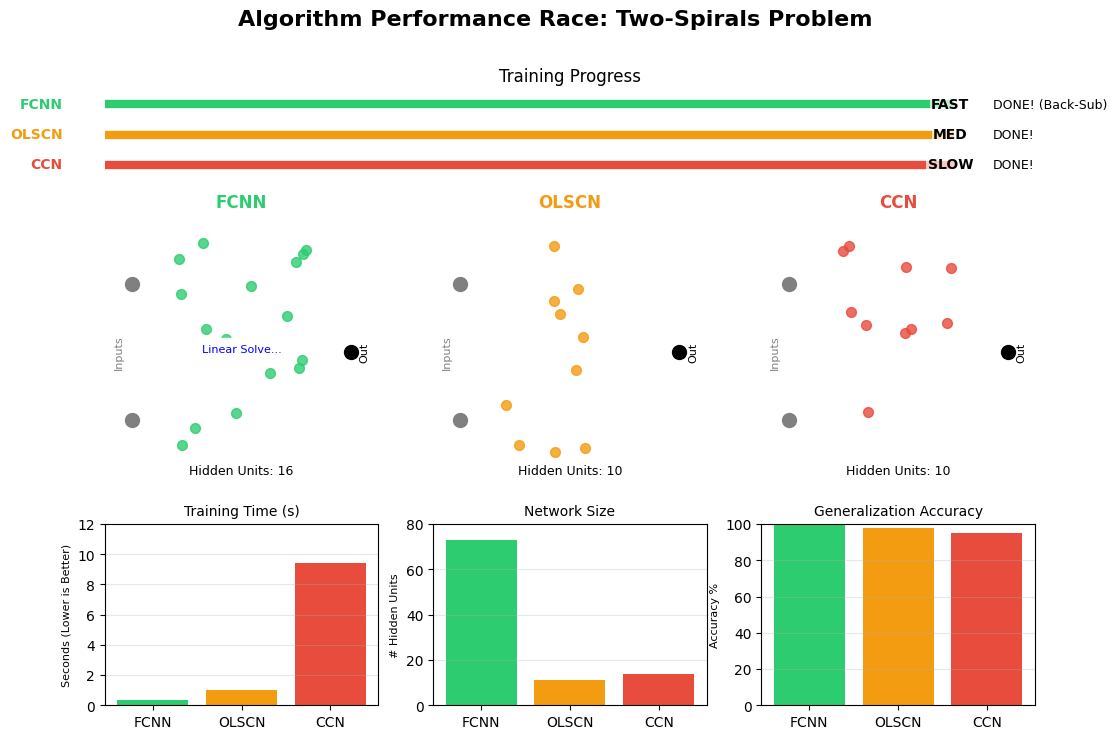

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
import random

# --- CONFIGURATION & DATA ---
DURATION_FCNN = 30
DURATION_OLSCN = 70
DURATION_CCN = 130
TOTAL_FRAMES = 160

# Data config - Replaced icons with text to avoid font warnings
DATA = {
    'FCNN': {'color': '#2ecc71', 'icon': 'FAST', 'real_time': 0.33, 'units': 73, 'acc': 99.5},
    'OLSCN': {'color': '#f39c12', 'icon': 'MED', 'real_time': 1.00, 'units': 11, 'acc': 98.0},
    'CCN': {'color': '#e74c3c', 'icon': 'SLOW', 'real_time': 9.44, 'units': 14, 'acc': 95.0}
}

ALGOS = ['FCNN', 'OLSCN', 'CCN']

# --- SETUP FIGURE ---
fig = plt.figure(figsize=(12, 8), facecolor='white')
fig.suptitle("Algorithm Performance Race: Two-Spirals Problem", fontsize=16, weight='bold')

gs = GridSpec(3, 3, height_ratios=[0.5, 1.5, 1])

# 1. Top Row: Race Tracks
ax_race = fig.add_subplot(gs[0, :])
ax_race.axis('off')

# 2. Middle Row: Network Architecture
ax_nets = []
for i in range(3):
    ax = fig.add_subplot(gs[1, i])
    ax_nets.append(ax)

    # Static setup for networks
    ax.set_title(ALGOS[i], weight='bold', color=DATA[ALGOS[i]]['color'])
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.axis('off')

    # Draw Inputs (Static - Index 0 in collections)
    ax.scatter([-0.8, -0.8], [-0.5, 0.5], c='gray', s=100, zorder=5)
    ax.text(-0.9, 0, "Inputs", rotation=90, va='center', ha='center', fontsize=8, color='gray')

    # Draw Output (Static - Index 1 in collections)
    ax.scatter([0.8], [0], c='black', s=100, zorder=5)
    ax.text(0.9, 0, "Out", rotation=90, va='center', ha='center', fontsize=8)

# 3. Bottom Row: Statistics
ax_time = fig.add_subplot(gs[2, 0])
ax_units = fig.add_subplot(gs[2, 1])
ax_acc = fig.add_subplot(gs[2, 2])

# Setup Chart axes
def setup_bar_chart(ax, title, ylabel, ylim):
    ax.set_title(title, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=8)
    ax.set_ylim(0, ylim)
    ax.set_xticks(range(3))
    ax.set_xticklabels(ALGOS)
    ax.grid(axis='y', alpha=0.3)

setup_bar_chart(ax_time, "Training Time (s)", "Seconds (Lower is Better)", 12)
setup_bar_chart(ax_units, "Network Size", "# Hidden Units", 80)
setup_bar_chart(ax_acc, "Generalization Accuracy", "Accuracy %", 100)

# Initialize Bars
bars_time = ax_time.bar(ALGOS, [0,0,0], color=[DATA[a]['color'] for a in ALGOS])
bars_units = ax_units.bar(ALGOS, [0,0,0], color=[DATA[a]['color'] for a in ALGOS])
bars_acc = ax_acc.bar(ALGOS, [0,0,0], color=[DATA[a]['color'] for a in ALGOS])

# --- STATE MANAGEMENT ---
algo_state = {
    'FCNN': {'nodes_x': [], 'nodes_y': [], 'status': '', 'finished': False, 'progress': 0},
    'OLSCN': {'nodes_x': [], 'nodes_y': [], 'status': '', 'finished': False, 'progress': 0},
    'CCN': {'nodes_x': [], 'nodes_y': [], 'status': '', 'finished': False, 'progress': 0}
}

# --- ANIMATION FUNCTION ---
def update(frame):

    # 1. Update Logic for each Algo
    for algo, duration in zip(ALGOS, [DURATION_FCNN, DURATION_OLSCN, DURATION_CCN]):
        props = DATA[algo]
        state = algo_state[algo]

        if not state['finished']:
            prog = min(100, (frame / duration) * 100)
            state['progress'] = prog

            if prog < 100:
                if algo == 'FCNN':
                    state['status'] = "Gen. Random Node..." if frame % 5 == 0 else "Frozen Weights"
                    if frame % 2 == 0:
                        state['nodes_x'].append(random.uniform(-0.5, 0.5))
                        state['nodes_y'].append(random.uniform(-0.8, 0.8))
                elif algo == 'OLSCN':
                    state['status'] = "Gram-Schmidt..." if frame % 10 < 5 else "Minimizing Error..."
                    if frame % 8 == 0:
                        state['nodes_x'].append(random.uniform(-0.5, 0.5))
                        state['nodes_y'].append(random.uniform(-0.8, 0.8))
                elif algo == 'CCN':
                    state['status'] = "Gradient Descent..." if frame % 10 < 7 else "Updating Weights..."
                    if frame % 15 == 0:
                        state['nodes_x'].append(random.uniform(-0.5, 0.5))
                        state['nodes_y'].append(random.uniform(-0.8, 0.8))
            else:
                state['finished'] = True
                state['progress'] = 100
                state['status'] = "DONE! (Back-Sub)" if algo == 'FCNN' else "DONE!"

    # 2. Draw Race Tracks
    ax_race.clear()
    ax_race.set_xlim(0, 110)
    ax_race.set_ylim(-0.5, 2.5)
    ax_race.axis('off')
    ax_race.set_title("Training Progress", fontsize=12)

    for i, algo in enumerate(reversed(ALGOS)):
        props = DATA[algo]
        state = algo_state[algo]
        y_pos = i

        # Track line
        ax_race.plot([0, 100], [y_pos, y_pos], c='lightgray', lw=2, zorder=1)

        # Progress bar
        ax_race.plot([0, state['progress']], [y_pos, y_pos], c=props['color'], lw=6, zorder=2)

        # Icon marker (Text now)
        ax_race.text(state['progress'], y_pos, props['icon'], fontsize=10, weight='bold',
                     va='center', ha='center', zorder=3, color='black',
                     bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1))

        # Label
        ax_race.text(-5, y_pos, algo, va='center', ha='right', weight='bold', color=props['color'])

        # Status Text
        ax_race.text(105, y_pos, state['status'], va='center', ha='left', fontsize=9)

    # 3. Draw Networks
    for i, algo in enumerate(ALGOS):
        ax = ax_nets[i]
        state = algo_state[algo]
        props = DATA[algo]

        # --- FIX: PROPERLY CLEAR DYNAMIC ELEMENTS ---
        # Remove all lines (connections)
        for line in list(ax.lines):
            line.remove()

        # Remove dynamic collections (hidden nodes).
        # We assume the first 2 collections are Static Inputs and Static Outputs created in setup.
        # We remove anything added after that.
        while len(ax.collections) > 2:
            ax.collections[-1].remove()

        # Remove dynamic texts.
        # Setup created 2 texts ("Inputs", "Out"). Remove anything added after.
        while len(ax.texts) > 2:
            ax.texts[-1].remove()

        # --- DRAW NEW ELEMENTS ---
        if len(state['nodes_x']) > 0:
            # Draw hidden nodes (New collection)
            ax.scatter(state['nodes_x'], state['nodes_y'], c=props['color'], s=50, alpha=0.8)

            # Draw connections
            if not state['finished']:
                # Connection to input
                ax.plot([-0.8, state['nodes_x'][-1]], [0, state['nodes_y'][-1]], c=props['color'], alpha=0.3, lw=1)
                # Connection to output
                ax.plot([state['nodes_x'][-1], 0.8], [state['nodes_y'][-1], 0], c='black', alpha=0.3, lw=1)

        # Show node count
        ax.text(0, -0.9, f"Hidden Units: {len(state['nodes_x'])}", ha='center', fontsize=9)

        if algo == 'FCNN' and state['finished']:
            ax.text(0, 0, "Linear Solve...", color='blue', ha='center', fontsize=8, backgroundcolor='white')

    # 4. Update Charts
    for i, algo in enumerate(ALGOS):
        state = algo_state[algo]
        props = DATA[algo]

        if state['finished']:
            bars_time[i].set_height(props['real_time'])
            bars_units[i].set_height(props['units'])
            bars_acc[i].set_height(props['acc'])
        else:
            current_sim_time = (frame / duration) * props['real_time'] if duration > 0 else 0
            bars_time[i].set_height(current_sim_time)
            bars_units[i].set_height(len(state['nodes_x']))
            bars_acc[i].set_height(10 + (state['progress']/100)*40)

    return []

# --- GENERATE & SAVE ---
print("Generating Animation...")
ani = animation.FuncAnimation(fig, update, frames=TOTAL_FRAMES, interval=50, blit=False)
output_file = 'fcnn_race_simulation.gif'
ani.save(output_file, writer='pillow', fps=20)
print(f"Animation saved to {output_file}")